# Feature engineering

## Cargando librerías

In [1]:
import pandas as pd
import pickle
import datetime
import time
import numpy as np
import math as m

In [2]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [3]:
from sklearn.tree import DecisionTreeClassifier

## Funciones de ingesta y transformación

In [16]:
# Funciones solicitadas

def load_ingestion(path='output/ingest_df.pkl'):
    """
    Recibe el path en donde se encuentra el pickle que generamos durante la ingestión.
    :param: path
    :return: pickle
    """
    # Recibe ingest_df.pkl
    df_pkl = pickle.load(open(path, "rb"))
    return df_pkl
    # utils function
    #load_df(path)
    
def generate_label(df):
    """
    Crea en el data frame de los datos la variable label que es 1
    cuando el código de cierre es 'Pass','Pass w/ Conditions', 0 en caso de 'Fail'.
    :param: dataframe
    :return: dataframe
    """
    df['label'] = np.where(df.results.isin(['Pass','Pass w/ Conditions']), 1, 0)
    return df


def date_transformation(col, df):
    """
    Recibe la columna que hay que transformar a DATE y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return pd.to_datetime(df[col])

def numeric_transformation(col, df):
    """
    Recibe la columna que hay que transformar a NUMERIC (entera) y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return df[col].astype(float) 

def int_transformation(col, df):
    """
    Recibe la columna que hay que transformar a NUMERIC (entera) y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return df[col].astype(int)

def categoric_trasformation(col, df):
    """
    Recibe la columna que hay que transformar a CATEGORICA y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return df[col].astype(str) 

  
def save_transformation(df, path='output/transformation_df.pkl'):
    """
    Guarda en formato pickle (ver notebook feature_engineering.ipynb)
    el data frame que ya tiene los datos transformados.
    El pickle se debe llamar transformation_df.pkl y se debe guardar
    en la carpeta output.
    :param: dataframe, path
    :return: file save
    """
    pickle.dump(df, open(path, "wb"))
    # utils function, debería guardar el pickle llamado transformation_df.pkl en la carpeta ouput
    # save_df(df, path)

## Funciones de feature enginering

In [20]:
# Funciones solicitadas

def load_transformation(path='output/transformation_df.pkl'): 
    """
    Recibe el path en donde se encuentra el pickle que generamos 
    durante la transformación.
    """
    df_pkl = pickle.load(open(path, "rb"))
    return df_pkl
    # utils function
    #load_df(path)
    
def feature_generation(data): 
    """
    Recibe el data frame que contiene las variables a partir de las cuales 
    crearemos nuevas variables. Estas nuevas variables se guardarán en este 
    mismo data frame.
    """    
    # Creación de variables
    # Dividiendo fecha en mes y día, y creando semanas
    data = split_fecha("inspection_date", data)
    
    # Para crear variables ciclícas
    data = ciclic_variables('day_of_week', data)
    data = ciclic_variables('week', data)
    data = ciclic_variables('inspection_date_mes', data)
    data = ciclic_variables('inspection_date_dia', data)
    
    # Distancia al centroide
    data = get_distance(data)
    
    # Variables posibles a transformar
    """
    'type','risk','zip','weekday','distance',
    'sin_day_no','cos_day_no','sin_week','cos_week',
    'sin_month','cos_month','sin_days','cos_days'
    """
    # Variables a transformar
    data_input = pd.DataFrame(data,
                              columns=['type','risk','zip','weekday',
                                       'distance',
                                       'sin_day_no','cos_day_no','sin_week','cos_week',
                                       'sin_month','cos_month','sin_days','cos_days'])
    # Transformaciones
    transformers_2 = [('one_hot', OneHotEncoder(), ['type','risk','zip','weekday']),
                      ('min_max', MinMaxScaler(), ['distance',
                                                   'sin_day_no','cos_day_no','sin_week','cos_week',
                                                   'sin_month','cos_month','sin_days','cos_days'])]

    col_trans_2 = ColumnTransformer(transformers_2, remainder="drop", n_jobs=-1, verbose=True)
    col_trans_2.fit(data_input)

    input_vars = col_trans_2.transform(data_input)    
    # Solo para medir metricas
    pickle.dump(input_vars, open("output/feature_selection_input_vars_DPA.pkl", "wb"))

    cols = ['Assistance_service', 'BanquetService/Church', 'Bar', 'Coffe shop',
            'Drug/Grocery', 'Entertainment services', 'Gas station/Grosery',
            'Grocery/Almacen/Convenience store', 'Health store', 'Kiosko', 'Others',
            'Restaurant', 'School',
            'Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)',
            '60601', '60602', '60603', '60604', '60605', '60606', '60607', '60608',
            '60609', '60610', '60611', '60612', '60613', '60614', '60615', '60616',
            '60617', '60618', '60619', '60620', '60621', '60622', '60623', '60624',
            '60625', '60626', '60627', '60628', '60629', '60630', '60631', '60632',
            '60633', '60634', '60636', '60637', '60638', '60639', '60640', '60641',
            '60642', '60643', '60644', '60645', '60646', '60647', '60649', '60651',
            '60652', '60653', '60654', '60655', '60656', '60657', '60659', '60660',
            '60661', '60666', '60707', '60827',             
            #'Fail', 'Pass', 'Pass w/ Conditions',
            #'latitude','longitude',
            'N','Y',
            'distance',
            'sin_day_no','cos_day_no','sin_week','cos_week',
            'sin_month','cos_month','sin_days','cos_days']

    # Información del dataframe final
    df_final = pd.DataFrame(input_vars.todense())
    df_final.columns = cols    
        
    #df_final['inspection_date']= data['inspection_date']
    df_final['label']= data['label']
    
    return df_final
   
    
def feature_selection(data): 
    """
    Recibe el data frame que contiene las variables de las cuales haremos
    una selección.
    """
    X = data
    y = data.label
    X = pd.DataFrame(X.drop(['label'], axis=1))
    
    np.random.seed(20201124)

    ## Dividiendo datos en train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=None)

    # ocuparemos un RF
    classifier = RandomForestClassifier(oob_score=True, random_state=1234)

    # Definicion de los hiperparametros que queremos probar
    hyper_param_grid = {'n_estimators': [100, 300],
                        'max_depth': [1, 10, 15],
                        'min_samples_split': [2, 5]}

    tscv = TimeSeriesSplit(n_splits=3)
    
    # Ocupemos grid search!
    gs = GridSearchCV(classifier,
                      hyper_param_grid,
                      scoring='precision',
                      cv = tscv,
                      n_jobs = 3)

    # ejecutando el RF
    start_time = time.time()
    gs.fit(X_train, y_train)
    print("El proceso en segundos duro: ", time.time() - start_time)
    print("Mejores parámetros: " + str(gs.best_params_))
    print("Score:" + str(print(gs.best_score_)))
    best_e = gs.best_estimator_
    print("Mejor estimador: " + str(best_e))
    print("Mejor estimador observado: " + str(gs.best_estimator_.oob_score_))
    
    cols = ['Assistance_service', 'BanquetService/Church', 'Bar', 'Coffe shop',
            'Drug/Grocery', 'Entertainment services', 'Gas station/Grosery',
            'Grocery/Almacen/Convenience store', 'Health store', 'Kiosko', 'Others',
            'Restaurant', 'School',
            'Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)',
            '60601', '60602', '60603', '60604', '60605', '60606', '60607', '60608',
            '60609', '60610', '60611', '60612', '60613', '60614', '60615', '60616',
            '60617', '60618', '60619', '60620', '60621', '60622', '60623', '60624',
            '60625', '60626', '60627', '60628', '60629', '60630', '60631', '60632',
            '60633', '60634', '60636', '60637', '60638', '60639', '60640', '60641',
            '60642', '60643', '60644', '60645', '60646', '60647', '60649', '60651',
            '60652', '60653', '60654', '60655', '60656', '60657', '60659', '60660',
            '60661', '60666', '60707', '60827',             
            #'Fail', 'Pass', 'Pass w/ Conditions',
            #'latitude','longitude',
            'N','Y',
            'distance',
            'sin_day_no','cos_day_no','sin_week','cos_week',
            'sin_month','cos_month','sin_days','cos_days']


    # Importancia de los parámetros
    feature_importance = pd.DataFrame({'importance': best_e.feature_importances_,
                                       'feature': list(cols)})
    print("Importancia de los parámetros")
    print(feature_importance.sort_values(by="importance", ascending=False))

    # Salvando el mejor modelo obtenido
    #save_fe(best_e, path='../output/feature_selection_model_DPA.pkl')
    save_fe(best_e, path='output/feature_selection_model_DPA.pkl')

    # Regresando dataframe con los features que ocuparemos.
    # En este caso las variables que aportan más del 7% de información son:
    final_df = data[[
                            # Variables que aportan 7%
                            'distance',
                            'sin_days','cos_days',
                            'sin_week','cos_week',    
                            # Variables que aportan 4% y 3%
                            'sin_day_no','cos_day_no','sin_month','cos_month',
                            # Variables que aportan 1.5% aprox
                            'Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)',
                            'Assistance_service', 'BanquetService/Church', 'Bar', 'Coffe shop',
                            'Drug/Grocery', 'Entertainment services', 'Gas station/Grosery',
                            'Grocery/Almacen/Convenience store', 'Health store', 'Kiosko', 'Others',
                            'Restaurant', 'School',
                            'label'
                         ]]    

    return final_df

    
def save_fe(df, path='output/fe_df.pkl'):
    """
    Guarda en formato pickle (ver notebook feature_engineering.ipynb) el data frame 
    que ya tiene los features que ocuparemos. El pickle se debe llamar fe_df.pkl y 
    se debe guardar en la carpeta output.
    """    
    pickle.dump(df, open(path, "wb"))##en jupyter
    # utils function, debería guardar el picjle llamado fe_df.pkl en la carpeta ouput
    #save_df(df, path)# en .py
    

# --------------------- Funciones Auxiliares ---------------------------    
def split_fecha(col, df):
    """
    Recibe la columna fecha que hay que transformar en 3 columnas: año, mes, dia y 
    el data frame al que pertenece.
    :param: column, dataframe
    :return: dataframe con 2 columnas mas (mes, día) y semanas
    """
    df[col + '_mes'] = df[col].dt.month.astype(str) 
    df[col + '_dia'] = df[col].dt.day.astype(str)     
    
    # Cambio a enteros
    df[col + '_mes'] = int_transformation(col + '_mes', df)
    df[col + '_dia'] = int_transformation(col + '_dia', df)
    
    df['week'] = df[col].dt.week
    df['day_of_week'] = df[col].dt.day_name()
    #FIN DE SEMANA
    df['weekday']=df[col].map(lambda x: 'Y' if x.weekday()<5 else 'N')
    
    return df


def get_distance(df):
    """
    Genera centroide de latitud y longitu con medias y calcula distancias
    :param: dataframe
    :return: dataframe
    """
    lat_c = df['latitude'].median()
    lon_c = df['longitude'].median()
    
    df['lat'] = lat_c.astype(float) - df['latitude'].astype(float) 
    df['lon'] = lon_c.astype(float) - df['longitude'].astype(float) 
    
    df['distance'] = np.sqrt(df['lat']**2+df['lon']**2)

    df = pd.DataFrame(df.drop(['lat','lon'], axis=1))
    
    return df

def ciclic_variables(col, df):
    """
    Recibe la columna day_no, mes o fecha_creacion y las convierte en variables cíclicas:
    número día de la semana, mes, semana y hora respectivamente.
    :param: column, dataframe
    :return: dataframe con variable cíclica creada corresondientemente
    """
    
    if (col == 'day_of_week'):
        no_dia_semana = {'Sunday':1, 'Monday':2, 'Tuesday':3, 'Wednesday':4, 
                         'Thursday':5, 'Friday':6, 'Saturday':7}
        df['day_no'] = df[col].apply(lambda x: no_dia_semana[x])
        #max_day_no = np.max(df['day_no'])
        max_day_no = 7
        df['sin_day_no'] = np.sin(2*np.pi*df['day_no']/max_day_no)
        df['cos_day_no'] = np.cos(2*np.pi*df['day_no']/max_day_no)
        
    if(col == 'week'):
        # converting the hour into a sin, cos coordinate
        WEEKS = 53
        df['sin_week'] = np.sin(2*np.pi*df[col]/WEEKS)
        df['cos_week'] = np.cos(2*np.pi*df[col]/WEEKS) 
        
    if(col == 'inspection_date_mes'):
        MONTH = 12
        df['sin_month'] = np.sin(2*np.pi*df[col]/MONTH)
        df['cos_month'] = np.cos(2*np.pi*df[col]/MONTH) 
        
    if(col == 'inspection_date_dia'):
        # converting the hour into a sin, cos coordinate
        DAYS = 31
        df['sin_days'] = np.sin(2*np.pi*df[col]/DAYS)
        df['cos_days'] = np.cos(2*np.pi*df[col]/DAYS)    
            
    return df
    


In [18]:
def clean(df):
    """
    Recibe un dataframe y le aplica limpieza de datos
    :param: dataframe
    :return: dataframe
    """
    # Nos quedamos sólo con los resultados 'Pass','Pass w/ Conditions', 'Fail
    df = df[df.results.isin(['Pass','Pass w/ Conditions', 'Fail'])]
    
    # Podemos tomar sólo los de tipo Canvass (Sondeo)
    df = df[df.inspection_type.isin(['Canvass','CANVAS'])]
    
    # Generamos el label
    df = generate_label(df)
    
    # Quitamos NA
    df = df[df['facility_type'].notna()]
    df = df[df['risk'].notna()]
    df = df[df['city'].notna()]
    df = df[df['state'].notna()]
    df = df[df['zip'].notna()]
    df = df[df['latitude'].notna()]
    df = df[df['longitude'].notna()]
    df = df[df['location'].notna()]
    
    # Nos quedamos con las variables para predecir 
    df = df[['facility_type','risk', 'zip',
             'inspection_date','latitude','longitude','label']]
    
    # Quitamos duplicados
    df = df.drop_duplicates()
    
    # Agrupamos establecimientos
    df = agrupa_tipos(df)    
    
    return df



def agrupa_tipos(df_final):
    """
    Agrupa los tipos de establecimientos
    :param: dataframe
    :return: dataframe
    """
    # Se pasa a minúsculas
    df_final["facility_type"] = df_final["facility_type"].str.lower().str.strip()
    # Se hace una copia de la variable
    df_final["type"] = df_final["facility_type"]
    # Comenzamos a agrupar
    df_final['type'] = df_final['type'].replace(["1023",
                                                "1023 childern's service facility",
                                                "1023 childern's service s facility",
                                                "1023 childern's services facility",
                                                "1023 children's services facility",
                                                "1023-children's services facility",
                                                "15 monts to 5 years old",
                                                "adult daycare",
                                                "assissted living",
                                                "assisted living",
                                                "assisted living senior care",
                                                "catering",
                                                "charity aid kitchen",
                                                "childern's service facility",
                                                "childrens services facility",
                                                "children's services facility",
                                                "day care 1023",
                                                "day care 2-14",
                                                "daycare",
                                                "daycare (2 - 6 years)",
                                                "daycare (2 years)",
                                                "daycare (under 2 years)",
                                                "daycare 2 yrs to 12 yrs",
                                                "daycare above and under 2 years",
                                                "daycare combo 1586",
                                                "daycare night",
                                                "long term care",
                                                "long term care facility",
                                                "long-term care",
                                                "long-term care facility",
                                                "non -profit",
                                                "nursing home",
                                                "rehab center",
                                                "senior day care",
                                                "shelter",
                                                "supportive living",
                                                "supportive living facility",
                                                "youth housing",
                                                ],"Assistance_service")

    df_final['type'] = df_final['type'].replace(["banquet",
                                                "banquet dining",
                                                "banquet facility",
                                                "banquet hall",
                                                "banquet hall/catering",
                                                "banquet room",
                                                "banquet rooms",
                                                "banquet/kitchen",
                                                "banquets",
                                                "banquets/room service",
                                                "bowling lanes/banquets",
                                                "catering/banquet",
                                                "church",
                                                "church (special events)",
                                                "church kitchen",
                                                "church/day care",
                                                "church/special event",
                                                "church/special events",
                                                "event space",
                                                "lounge/banquet hall",
                                                "special event",],"BanquetService/Church")

    df_final['type'] = df_final['type'].replace(["bar",
                                                "bar/grill",
                                                "brewery",
                                                "brewpub",
                                                "juice and salad bar",
                                                "juice bar",
                                                "juice bar/grocery",
                                                "liquor/grocery store/bar",
                                                "restuarant and bar",
                                                "smoothie bar",
                                                "tavern",
                                                "wine tasting bar",],"Bar")

    df_final['type'] = df_final['type'].replace(["cafe/store",
                                                "cafeteria",
                                                "catering/cafe",
                                                "coffee  shop",
                                                "coffee cart",
                                                "coffee kiosk",
                                                "coffee shop",
                                                "coffee/tea",
                                                "liquor/coffee kiosk"],"Coffe shop")

    df_final['type'] = df_final['type'].replace(["drug store",
                                                "drug store/grocery",
                                                "drug treatment facility",
                                                "drug/food store",
                                                "grocery/drug store"],"Drug/Grocery")

    df_final['type'] = df_final['type'].replace(["art center",
                                                "blockbuster video",
                                                "boys and girls club",
                                                "day spa",
                                                "movie theater",
                                                "movie theatre",
                                                "music venue",
                                                "night club",
                                                "not-for-profit club",
                                                "pool",
                                                "social club",
                                                "stadium",
                                                "theater",
                                                "theatre",
                                                "vfw hall",
                                                "video store"],"Entertainment services")

    df_final['type'] = df_final['type'].replace(["convenience/gas station",
                                                "gas station",
                                                "gas station /grocery",
                                                "gas station store",
                                                "gas station/ grocery store",
                                                "gas station/convenience store",
                                                "gas station/food",
                                                "gas station/grocery",
                                                "gas station/mini mart",
                                                "gas station/restaurant",
                                                "gas station/store",
                                                "gas station/store grocery",
                                                "grocery store / gas station",
                                                "grocery store/gas station",
                                                "grocery/gas station",
                                                "grocery/service gas station",
                                                "retail food/gas station",
                                                "service gas station"],"Gas station/Grosery")

    df_final['type'] = df_final['type'].replace(["(convenience store)",
                                                "bakery",
                                                "bakery/deli",
                                                "butcher shop",
                                                "candy shop",
                                                "candy store",
                                                "candy/gelato",
                                                "chinese herbs",
                                                "cold/frozen food storage",
                                                "commiasary",
                                                "commissary",
                                                "commissary for soft serve ice cream trucks",
                                                "convenience",
                                                "convenience store",
                                                "convenience/drug store",
                                                "convenient store",
                                                "convnience store",
                                                "deli",
                                                "deli/grocery store",
                                                "distribution center",
                                                "donut shop",
                                                "fish market",
                                                "fitness center",
                                                "french market space",
                                                "gelato shop",
                                                "golf course conncession stand",
                                                "grocery",
                                                "grocery and butcher",
                                                "grocery store",
                                                "grocery/bakery",
                                                "grocery/butcher",
                                                "grocery/deli",
                                                "grocery/dollar store",
                                                "grocery/liquor store",
                                                "gym store",
                                                "ice cream",
                                                "ice cream shop",
                                                "kitchen demo",
                                                "liquor",
                                                "liquor store",
                                                "meat packing",
                                                "packaged liquor",
                                                "paleteria",
                                                "paleteria /icecream shop",
                                                "pantry",
                                                "popcorn shop",
                                                "prepacakaged foods",
                                                "prepackage meal distributor (1006 retail)",
                                                "rest/grocery",
                                                "retail store offers cooking classes",
                                                "shakes/teas",
                                                "slaughter house/ grocery",
                                                "snack shop",
                                                "store",
                                                "warehouse",
                                                "wholesale"],"Grocery/Almacen/Convenience store")

    df_final['type'] = df_final['type'].replace(["health care store",
                                                "health center",
                                                "herbal",
                                                "herbal drinks",
                                                "herbal life shop",
                                                "herbal medicine",
                                                "herbal remedy",
                                                "herbal store",
                                                "herbalife",
                                                "herbalife nutrition",
                                                "herbalife/zumba",
                                                "hospital",
                                                "nutrition store",
                                                "packaged health foods",
                                                "repackaging plant",
                                                "weight loss program",],"Health store")

    df_final['type'] = df_final['type'].replace(["hot dog station",
                                                "kiosk",
                                                "mobile food dispenser",
                                                "mobile food preparer",
                                                "navy pier kiosk",
                                                "newsstand",
                                                "o'hare kiosk"],"Kiosko")

    df_final['type'] = df_final['type'].replace(["bakery/ restaurant",
                                                "bakery/restaurant",
                                                "commisary restaurant",
                                                "dining hall",
                                                "employee kitchen",
                                                "golden diner",
                                                "grocery & restaurant",
                                                "grocery store/ restaurant",
                                                "grocery store/bakery",
                                                "grocery store/taqueria",
                                                "grocery& restaurant",
                                                "grocery(sushi prep)",
                                                "grocery/ restaurant",
                                                "grocery/restaurant",
                                                "grocery/taqueria",
                                                "main kitchen",
                                                "restaurant",
                                                "restaurant(protein shake bar)",
                                                "restaurant.banquet halls",
                                                "restaurant/bakery",
                                                "restaurant/bar",
                                                "restaurant/grocery",
                                                "restaurant/grocery store",
                                                "restaurant/hospital",
                                                "roof top",
                                                "roof tops",
                                                "rooftop",
                                                "rooftops",
                                                "shared kitchen",
                                                "shared kitchen user (long term)",
                                                "shared kitchen user (short term)",
                                                "smokehouse",
                                                "summer feeding",
                                                "summer feeding prep area",
                                                "sushi counter",
                                                "tavern grill",
                                                "tavern/restaurant",
                                                "theater & restaurant",
                                                "wrigley roof top",
                                                "wrigley rooftop"],"Restaurant")

    df_final['type'] = df_final['type'].replace(["after school program",
                                                "a-not-for-profit chef training program",
                                                "before and after school program",
                                                "charter",
                                                "charter school",
                                                "charter school cafeteria",
                                                "city of chicago college",
                                                "college",
                                                "cooking school",
                                                "culinary arts school",
                                                "culinary class rooms",
                                                "culinary school",
                                                "grocery store/cooking school",
                                                "high school kitchen",
                                                "pastry school",
                                                "prep inside school",
                                                "private school",
                                                "public shcool",
                                                "school",
                                                "school cafeteria",
                                                "teaching school",
                                                "university cafeteria"],"School")

    df_final['type'] = df_final['type'].replace(["airport lounge",
                                                "beverage/silverware warehouse",
                                                "cell phone store",
                                                "custom poultry slaughter",
                                                "dollar store",
                                                "dollar store with grocery",
                                                "hostel",
                                                "hotel",
                                                "incubator",
                                                "live poultry",
                                                "northerly island",
                                                "other",
                                                "poultry slaughter",
                                                "regulated business",
                                                "rest/gym",
                                                "rest/rooftop",
                                                "riverwalk",
                                                "room service",
                                                "unused storage"],"Others")

    return df_final

# Transformation.py

## Carga de datos

In [7]:
data = pickle.load(open('output/2020-02-02_.pkl', "rb"))
data.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location
0,2484780,RED STAR LIQUORS,RED STAR LIQUORS,2432531,Grocery Store,Risk 2 (Medium),2725-2727 N MILWAUKEE AVE,CHICAGO,IL,60647,2021-02-11T00:00:00.000,Complaint Re-Inspection,Pass,57. ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAIN...,41.93078708970233,-87.70998753402094,"{'latitude': '-87.70998753402094', 'longitude'..."
1,2484768,MARZ COMMINITY BREWING CO.,MARZ COMMUNITY BREWING CO.,2770949,Liquor,Risk 3 (Low),1950 N WESTERN AVE,CHICAGO,IL,60647,2021-02-11T00:00:00.000,License,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",41.917134801370274,-87.68754385201615,"{'latitude': '-87.68754385201615', 'longitude'..."
2,2484766,LA FORTALEZA DE ARCELIA GUERRERO,LA FORTALEZA DE ARCELIA GUERRERO,2575370,Restaurant,Risk 1 (High),5958 W DIVERSEY AVE,CHICAGO,IL,60639,2021-02-11T00:00:00.000,Complaint Re-Inspection,Pass w/ Conditions,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,41.931249818095836,-87.7759069982422,"{'latitude': '-87.7759069982422', 'longitude':..."
3,2484759,Jimmy Johns,Jimmy Johns,1898470,Restaurant,Risk 1 (High),51 W DIVISION ST,CHICAGO,IL,60610,2021-02-11T00:00:00.000,Canvass Re-Inspection,Pass,NaN,41.903806014540685,-87.63058113117621,"{'latitude': '-87.63058113117621', 'longitude'..."
4,2484775,CAFE TOLA #4,CAFE TOLA,2627325,Restaurant,Risk 1 (High),2489 N MILWAUKEE AVE,CHICAGO,IL,60647,2021-02-11T00:00:00.000,Canvass Re-Inspection,Pass,NaN,41.92663502691596,-87.70319925259288,"{'latitude': '-87.70319925259288', 'longitude'..."


In [8]:
df_final = clean(data)

### Iniciamos transformaciones de datos

In [9]:
# Categoricas
df_final['type'] = categoric_trasformation('type', df_final)
df_final['facility_type'] = categoric_trasformation('facility_type', df_final)
df_final['risk'] = categoric_trasformation('risk', df_final)
df_final['address'] = categoric_trasformation('address', df_final)
df_final['zip'] = categoric_trasformation('zip', df_final)
# Númericas 
df_final['label'] = int_transformation('label', df_final)
df_final['latitude'] = numeric_transformation('latitude', df_final)
df_final['longitude'] = numeric_transformation('longitude', df_final)

In [10]:
# Transformando fechas.
df_final['inspection_date'] = date_transformation('inspection_date', df_final)


/home/aide/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/ipykernel_launcher.py:77: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [11]:
# Ordenando datos por fecha de inspección
df_final = df_final.sort_values(['inspection_date'])
df_final

,facility_type,risk,address,zip,inspection_date,latitude,longitude,label,type,inspection_date_mes,inspection_date_dia,week,day_of_week,weekday
216264,restaurant,Risk 1 (High),6 E CHESTNUT ST,60611,2010-01-04,41.898431,-87.628009,0,Restaurant,1,4,1,Monday,Y
216194,restaurant,Risk 1 (High),4852 S PULASKI RD,60632,2010-01-05,41.804468,-87.723633,1,Restaurant,1,5,1,Tuesday,Y
216200,restaurant,Risk 1 (High),7148 N HARLEM AVE,60631,2010-01-05,42.011357,-87.806788,1,Restaurant,1,5,1,Tuesday,Y
216210,school,Risk 1 (High),3616 W ARMITAGE AVE,60647,2010-01-05,41.917384,-87.717464,1,School,1,5,1,Tuesday,Y
216216,restaurant,Risk 2 (Medium),30 W ERIE ST,60654,2010-01-05,41.894165,-87.629389,1,Restaurant,1,5,1,Tuesday,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,restaurant,Risk 1 (High),3018 W CERMAK RD,60623,2021-02-10,41.851934,-87.701132,1,Restaurant,2,10,6,Wednesday,Y
24,restaurant,Risk 1 (High),1760 W CHICAGO AVE,60622,2021-02-10,41.896103,-87.672116,0,Restaurant,2,10,6,Wednesday,Y
15,restaurant,Risk 1 (High),3323 W NORTH AVE,60647,2021-02-10,41.909960,-87.710429,0,Restaurant,2,10,6,Wednesday,Y
13,restaurant,Risk 3 (Low),3012 W CERMAK RD,60623,2021-02-10,41.851939,-87.700898,1,Restaurant,2,10,6,Wednesday,Y


In [12]:
df_final = df_final.reset_index(drop=True)
df_final

,facility_type,risk,address,zip,inspection_date,latitude,longitude,label,type,inspection_date_mes,inspection_date_dia,week,day_of_week,weekday
0,restaurant,Risk 1 (High),6 E CHESTNUT ST,60611,2010-01-04,41.898431,-87.628009,0,Restaurant,1,4,1,Monday,Y
1,restaurant,Risk 1 (High),4852 S PULASKI RD,60632,2010-01-05,41.804468,-87.723633,1,Restaurant,1,5,1,Tuesday,Y
2,restaurant,Risk 1 (High),7148 N HARLEM AVE,60631,2010-01-05,42.011357,-87.806788,1,Restaurant,1,5,1,Tuesday,Y
3,school,Risk 1 (High),3616 W ARMITAGE AVE,60647,2010-01-05,41.917384,-87.717464,1,School,1,5,1,Tuesday,Y
4,restaurant,Risk 2 (Medium),30 W ERIE ST,60654,2010-01-05,41.894165,-87.629389,1,Restaurant,1,5,1,Tuesday,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,restaurant,Risk 1 (High),3018 W CERMAK RD,60623,2021-02-10,41.851934,-87.701132,1,Restaurant,2,10,6,Wednesday,Y
87016,restaurant,Risk 1 (High),1760 W CHICAGO AVE,60622,2021-02-10,41.896103,-87.672116,0,Restaurant,2,10,6,Wednesday,Y
87017,restaurant,Risk 1 (High),3323 W NORTH AVE,60647,2021-02-10,41.909960,-87.710429,0,Restaurant,2,10,6,Wednesday,Y
87018,restaurant,Risk 3 (Low),3012 W CERMAK RD,60623,2021-02-10,41.851939,-87.700898,1,Restaurant,2,10,6,Wednesday,Y


In [13]:
# Salvando dataframe transformado
pickle.dump(df_final, open("output/transformation_df_DPA.pkl", "wb"))

### Frecuencias tipo de establecimientos

In [14]:
prop_codigo = df_final.groupby(['facility_type'], as_index=False)['inspection_date']\
.count()\
.rename(columns={'inspection_date': 'count'})
prop_codigo['prop'] = prop_codigo['count']/np.sum(prop_codigo['count'])
prop_codigo.sort_values(by = ['prop'], ascending = False).head(60)

,facility_type,count,prop
219,restaurant,59766,0.686808
236,school,9607,0.110400
129,grocery store,8856,0.101770
16,bakery,1473,0.016927
54,children's services facility,1184,0.013606
89,daycare (2 - 6 years),835,0.009595
93,daycare above and under 2 years,830,0.009538
177,long term care,829,0.009527
45,catering,600,0.006895
124,golden diner,441,0.005068


In [41]:
df_final[df_final.type == 'otros'].groupby('facility_type')['label'].agg('mean').head(60)
#df_final.groupby('type')['label'].agg('mean')

Series([], Name: label, dtype: int64)

In [42]:
p = df_final.groupby(['type','label'], as_index=False)['inspection_date']\
.count()\
.rename(columns={'inspection_date': 'count'})
p['prop'] = p['count']/np.sum(p['count'])
p.sort_values(by = ['prop'], ascending = False).head(60)

,type,label,count,prop
23,Restaurant,1,47393,0.544622
22,Restaurant,0,13152,0.151138
15,Grocery/Almacen/Convenience store,1,7821,0.089876
25,School,1,7659,0.088014
1,Assistance_service,1,3922,0.045070
14,Grocery/Almacen/Convenience store,0,2905,0.033383
24,School,0,2154,0.024753
0,Assistance_service,0,847,0.009733
3,BanquetService/Church,1,273,0.003137
17,Health store,1,247,0.002838


NameError: name 'utils' is not defined

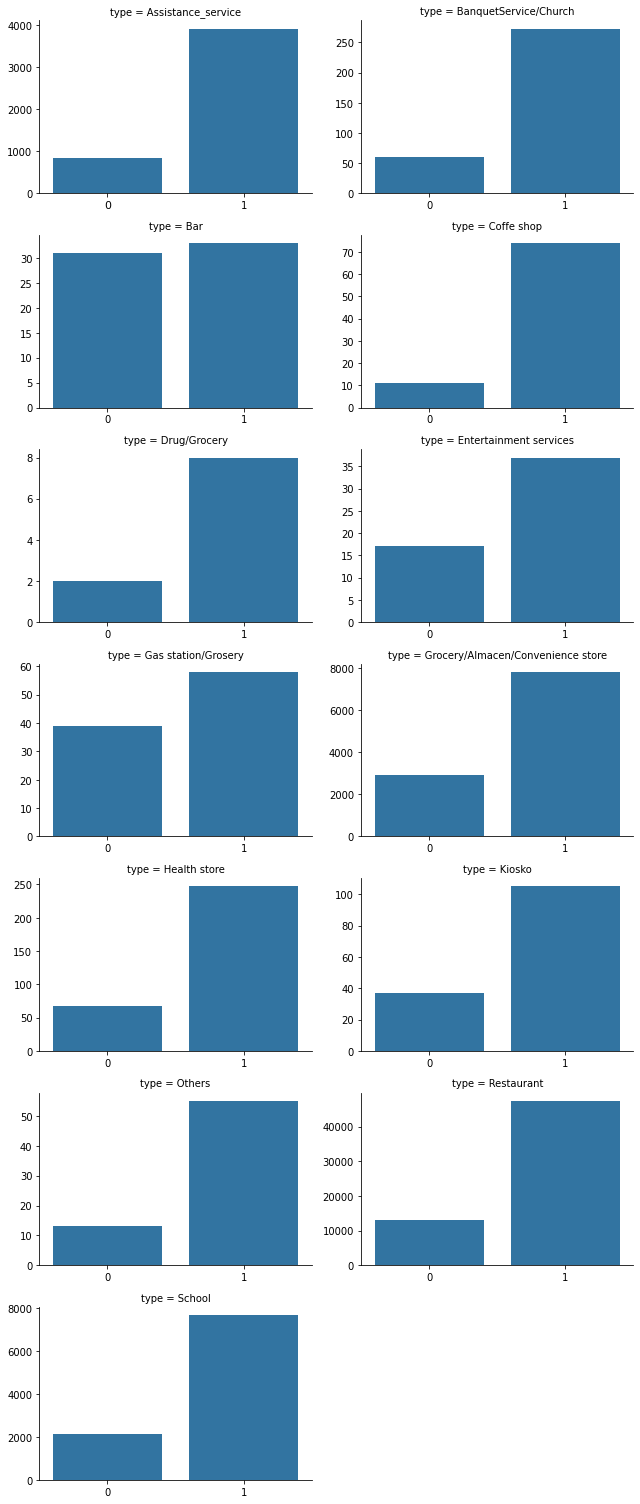

In [22]:
"""
import matplotlib.pyplot as plt
import seaborn as sns 
riesgo_label = df_final.groupby(['type', 'label'],
                          as_index=False)['inspection_date']\
                          .count()\
                          .rename(columns={'inspection_date': 'registros'})


import matplotlib.pyplot as plt
a = sns.FacetGrid(data=riesgo_label, col='type', col_wrap=2, sharex=False, sharey=False,
                 aspect=1.5)
a.map_dataframe(sns.barplot, x='label', y='registros')
for ax in a.axes.flat:
    for label in ax.get_xticklabels():
        label.set_size(11)
        #label.set_rotation(50)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(utils.number_formatter))
        a.fig.tight_layout()

plt.subplots_adjust(top=0.9)
aux = a.fig.suptitle("Distribución", fontsize=18)
"""


In [ ]:
# Obteniendo encabezados en one hot encoder
pd.get_dummies(df_final.type).columns

# Feature_engineering.py

In [21]:
# Carga pickle para feature generation
df_transform = load_transformation('output/transformation_df_DPA.pkl')
df_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   facility_type        87020 non-null  object        
 1   risk                 87020 non-null  object        
 2   address              87020 non-null  object        
 3   zip                  87020 non-null  object        
 4   inspection_date      87020 non-null  datetime64[ns]
 5   latitude             87020 non-null  float64       
 6   longitude            87020 non-null  float64       
 7   label                87020 non-null  int64         
 8   type                 87020 non-null  object        
 9   inspection_date_mes  87020 non-null  int64         
 10  inspection_date_dia  87020 non-null  int64         
 11  week                 87020 non-null  int64         
 12  day_of_week          87020 non-null  object        
 13  weekday              87020 non-

In [22]:
#in_v, fe_df = feature_generation(df_transform)
fe_df = feature_generation(df_transform)
fe_df

,Assistance_service,BanquetService/Church,Bar,Coffe shop,Drug/Grocery,Entertainment services,Gas station/Grosery,Grocery/Almacen/Convenience store,Health store,Kiosko,...,distance,sin_day_no,cos_day_no,sin_week,cos_week,sin_month,cos_month,sin_days,cos_days,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142089,1.000000,3.568959e-01,0.559163,0.996487,0.750000,0.933013,0.862862,0.844083,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.373700,0.722521,5.551115e-17,0.559163,0.996487,0.750000,0.933013,0.924867,0.763876,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.650035,0.722521,5.551115e-17,0.559163,0.996487,0.750000,0.933013,0.924867,0.763876,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.194456,0.722521,5.551115e-17,0.559163,0.996487,0.750000,0.933013,0.924867,0.763876,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.136071,0.722521,5.551115e-17,0.559163,0.996487,0.750000,0.933013,0.924867,0.763876,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.188008,0.277479,0.000000e+00,0.826554,0.878649,0.933013,0.750000,0.949479,0.277951,1
87016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015118,0.277479,0.000000e+00,0.826554,0.878649,0.933013,0.750000,0.949479,0.277951,0
87017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.160705,0.277479,0.000000e+00,0.826554,0.878649,0.933013,0.750000,0.949479,0.277951,0
87018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.187473,0.277479,0.000000e+00,0.826554,0.878649,0.933013,0.750000,0.949479,0.277951,1


In [23]:
fe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 88 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Assistance_service                 87020 non-null  float64
 1   BanquetService/Church              87020 non-null  float64
 2   Bar                                87020 non-null  float64
 3   Coffe shop                         87020 non-null  float64
 4   Drug/Grocery                       87020 non-null  float64
 5   Entertainment services             87020 non-null  float64
 6   Gas station/Grosery                87020 non-null  float64
 7   Grocery/Almacen/Convenience store  87020 non-null  float64
 8   Health store                       87020 non-null  float64
 9   Kiosko                             87020 non-null  float64
 10  Others                             87020 non-null  float64
 11  Restaurant                         87020 non-null  flo

In [24]:
df = feature_selection(fe_df)
df

El proceso en segundos duro:  160.14389157295227
Mejores parámetros: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}
0.7810254894620691
Score:None
Mejor estimador: RandomForestClassifier(max_depth=15, min_samples_split=5, oob_score=True,
                       random_state=1234)
Mejor estimador observado: 0.7851397051580917
Importancia de los parámetros
    importance       feature
78    0.151500      distance
85    0.101016      sin_days
86    0.090449      cos_days
81    0.088925      sin_week
82    0.081963      cos_week
..         ...           ...
67    0.000430         60655
76    0.000397             N
3     0.000389    Coffe shop
4     0.000018  Drug/Grocery
42    0.000001         60627

[87 rows x 2 columns]


,N,Y,distance,sin_days,cos_days,sin_week,cos_week,sin_day_no,cos_day_no,sin_month,...,Drug/Grocery,Entertainment services,Gas station/Grosery,Grocery/Almacen/Convenience store,Health store,Kiosko,Others,Restaurant,School,label
0,0.0,1.0,0.142089,0.862862,0.844083,0.559163,0.996487,1.000000,3.568959e-01,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.0,1.0,0.373700,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,0.0,1.0,0.650035,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,0.0,1.0,0.194456,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,0.0,1.0,0.136071,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87015,0.0,1.0,0.188008,0.949479,0.277951,0.826554,0.878649,0.277479,0.000000e+00,0.933013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
87016,0.0,1.0,0.015118,0.949479,0.277951,0.826554,0.878649,0.277479,0.000000e+00,0.933013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
87017,0.0,1.0,0.160705,0.949479,0.277951,0.826554,0.878649,0.277479,0.000000e+00,0.933013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
87018,0.0,1.0,0.187473,0.949479,0.277951,0.826554,0.878649,0.277479,0.000000e+00,0.933013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [25]:
# Se salva el dataframe con los features
save_fe(df, 'output/fe_df_DPA.pkl')

# DETALLE DEL FEATURE SELECTION

In [26]:
in_v = pickle.load(open('output/feature_selection_input_vars_DPA.pkl', "rb"))

In [27]:
from sklearn.feature_selection import VarianceThreshold

In [28]:
variance_threshold = VarianceThreshold(threshold=0.1)
variance_threshold.fit(in_v)
variance_threshold.transform(in_v).todense()

matrix([[0.        , 1.        , 0.        , ..., 0.9330127 , 0.86286212,
         0.84408348],
        [0.        , 1.        , 0.        , ..., 0.9330127 , 0.92486744,
         0.76387627],
        [0.        , 1.        , 0.        , ..., 0.9330127 , 0.92486744,
         0.76387627],
        ...,
        [0.        , 1.        , 0.        , ..., 0.75      , 0.94947917,
         0.27795062],
        [0.        , 1.        , 0.        , ..., 0.75      , 0.94947917,
         0.27795062],
        [0.        , 0.        , 1.        , ..., 0.75      , 0.94947917,
         0.27795062]])

In [29]:
variance_threshold.variances_

array([5.18000706e-02, 3.81206282e-03, 7.34922206e-04, 9.75832833e-04,
       1.14902906e-04, 6.20161922e-04, 1.11344375e-03, 1.08066235e-01,
       3.59534559e-03, 1.62914598e-03, 7.80818924e-04, 2.11678181e-01,
       1.00050743e-01, 1.63021776e-01, 1.38449220e-01, 3.75448974e-02,
       1.89884248e-02, 8.58959820e-03, 1.06966720e-02, 7.79847829e-03,
       1.57515642e-02, 2.13573349e-02, 2.72316210e-02, 2.59388745e-02,
       1.98933563e-02, 2.06314333e-02, 3.15388299e-02, 1.39795573e-02,
       2.42275960e-02, 3.72587734e-02, 8.86054139e-03, 2.08845296e-02,
       1.77717033e-02, 3.17106732e-02, 1.19318129e-02, 1.38343810e-02,
       6.58669397e-03, 3.16032790e-02, 2.57756579e-02, 8.86054139e-03,
       2.80119708e-02, 1.65962026e-02, 1.14914791e-05, 1.43701949e-02,
       1.87342837e-02, 1.52284586e-02, 9.16517064e-03, 2.60802809e-02,
       2.02987795e-03, 2.30137828e-02, 7.91157465e-03, 9.99909343e-03,
       1.43255670e-02, 2.33968680e-02, 2.57103546e-02, 2.09285321e-02,
      

In [30]:
X = in_v
y = fe_df.label.values.reshape(in_v.shape[0],)
print(X.shape, y.shape)

(87020, 87) (87020,)


In [31]:
np.random.seed(20201124)

In [32]:
# ocuparemos un RF
classifier = RandomForestClassifier(oob_score=True, random_state=1234)
# separando en train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [33]:
# definicion de los hiperparametros que queremos probar
hyper_param_grid = {'n_estimators': [100, 300], 
                    'max_depth': [1, 10, 15],
                    'min_samples_split': [2, 5]}

In [34]:
# ocupemos grid search!
tscv = TimeSeriesSplit(n_splits=3)
    
# Ocupemos grid search!
gs = GridSearchCV(classifier,
                  hyper_param_grid,
                  scoring='precision',
                  cv = tscv,
                  n_jobs = 3)#2

In [35]:
# ejecutando el RF
start_time = time.time()
gs.fit(X_train, y_train)
print("Tiempo en ejecutar: ", time.time() - start_time)

Tiempo en ejecutar:  185.50922536849976


**Mejores parámetros:**

In [36]:
gs.best_params_

{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}

**Score:**

In [37]:
gs.best_score_

0.777336063733311

**Mejor estimador:**

In [38]:
best_e = gs.best_estimator_
best_e

RandomForestClassifier(max_depth=15, oob_score=True, random_state=1234)

**feature_importances**

In [39]:
best_e.feature_importances_

array([1.01545147e-02, 1.10557529e-03, 1.99939348e-03, 4.85542628e-04,
       1.32822179e-04, 3.36688595e-04, 2.22532273e-03, 2.26655740e-02,
       1.67309352e-03, 7.49691779e-04, 4.89160662e-04, 1.36844854e-02,
       9.59690729e-03, 1.58819204e-02, 1.47879436e-02, 9.03742140e-03,
       5.03742793e-03, 1.75690041e-03, 1.15595179e-03, 8.16996947e-04,
       9.97718234e-04, 3.90723046e-03, 1.93822817e-03, 2.20124726e-03,
       1.85889780e-03, 1.40307051e-03, 1.97899751e-03, 2.68815275e-03,
       1.11488324e-03, 4.62869899e-03, 6.72666262e-03, 1.38639296e-03,
       9.36399418e-04, 5.17903505e-03, 6.27856292e-03, 3.63048268e-03,
       1.29408392e-03, 2.38177572e-03, 6.44001994e-03, 4.33496633e-03,
       7.96120610e-04, 3.10613372e-03, 0.00000000e+00, 4.51735272e-03,
       2.91472460e-03, 6.81846638e-04, 4.55764298e-04, 1.11113447e-03,
       4.00665848e-04, 3.83839220e-03, 3.15633222e-03, 3.77802179e-03,
       8.94069688e-03, 2.60495424e-03, 4.12004924e-03, 9.56751126e-04,
      

In [40]:
cols = ['Assistance_service', 'BanquetService/Church', 'Bar', 'Coffe shop',
            'Drug/Grocery', 'Entertainment services', 'Gas station/Grosery',
            'Grocery/Almacen/Convenience store', 'Health store', 'Kiosko', 'Others',
            'Restaurant', 'School',
            'Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)',
            '60601', '60602', '60603', '60604', '60605', '60606', '60607', '60608',
            '60609', '60610', '60611', '60612', '60613', '60614', '60615', '60616',
            '60617', '60618', '60619', '60620', '60621', '60622', '60623', '60624',
            '60625', '60626', '60627', '60628', '60629', '60630', '60631', '60632',
            '60633', '60634', '60636', '60637', '60638', '60639', '60640', '60641',
            '60642', '60643', '60644', '60645', '60646', '60647', '60649', '60651',
            '60652', '60653', '60654', '60655', '60656', '60657', '60659', '60660',
            '60661', '60666', '60707', '60827',             
            #'Fail', 'Pass', 'Pass w/ Conditions',
            #'latitude','longitude',
            'N','Y',
            'distance',
            'sin_day_no','cos_day_no','sin_week','cos_week',
            'sin_month','cos_month','sin_days','cos_days']

In [41]:
feature_importance = pd.DataFrame({'importance': best_e.feature_importances_,
                                  'feature': cols})

**Nombre de los campos con mayor importancia**

In [43]:
feature_importance.sort_values(by="importance", ascending=False).head(60)

,importance,feature
78,0.185248,distance
85,0.109891,sin_days
86,0.096965,cos_days
81,0.086905,sin_week
82,0.084275,cos_week
79,0.055971,sin_day_no
83,0.048431,sin_month
84,0.047534,cos_month
80,0.036245,cos_day_no
7,0.022666,Grocery/Almacen/Convenience store


In [44]:
gs.best_estimator_.oob_score_

0.7787700692779985

In [45]:
predicted_labels = gs.predict(X_test)

In [46]:
predicted_scores = gs.predict_proba(X_test)

In [47]:
predicted_scores[:10]

array([[0.22948432, 0.77051568],
       [0.19862597, 0.80137403],
       [0.215107  , 0.784893  ],
       [0.27177305, 0.72822695],
       [0.20779776, 0.79220224],
       [0.18222705, 0.81777295],
       [0.17053923, 0.82946077],
       [0.23806982, 0.76193018],
       [0.20858462, 0.79141538],
       [0.22425993, 0.77574007]])

**Guardando el mejor estimador**

In [48]:
#pickle.dump(best_e, open("output/feature_selection_model_DPA.pkl", "wb"))
#pickle.dump(gs, open("output/feature_selection_estimadores_DPA.pkl", "wb"))
#pickle.dump(in_v, open("output/feature_selection_input_vars_DPA.pkl", "wb"))

**Ahora se puede trabajar con el estimador obtenido sin volver a correr todo**

In [49]:
# Carga pickle
load_best_e = load_transformation('output/feature_selection_model_DPA.pkl')
load_best_e

RandomForestClassifier(max_depth=15, min_samples_split=5, oob_score=True,
                       random_state=1234)

In [50]:
final_df = pd.DataFrame(in_v.todense())
final_df.columns = cols

**Imprimiendo todos los fuatures por nivel de importancia**

In [51]:
feature_importance = pd.DataFrame({'importance': load_best_e.feature_importances_,
                                  'feature': list(final_df.columns)})
feature_importance.sort_values(by="importance", ascending=False).head(30)

,importance,feature
78,0.151500,distance
85,0.101016,sin_days
86,0.090449,cos_days
81,0.088925,sin_week
82,0.081963,cos_week
79,0.050634,sin_day_no
83,0.049175,sin_month
84,0.048376,cos_month
80,0.036280,cos_day_no
7,0.021520,Grocery/Almacen/Convenience store


In [52]:
feature_importance.sort_values(by="importance", ascending=False).tail(21)

,importance,feature
45,0.000954,60630
70,0.000936,60659
72,0.000936,60661
48,0.000882,60633
10,0.000832,Others
28,0.000830,60613
57,0.000823,60643
40,0.000820,60625
46,0.000812,60631
19,0.000780,60604


**Guardando el Dataframe con los features seleccionados**

In [53]:
#pickle.dump(final_df, open("output/fe_df_DPA.pkl", "wb"))

Vericicando que se haya guardado

In [54]:
df_fe = pickle.load(open('output/fe_df_DPA.pkl', "rb"))
df_fe.head(5)

,N,Y,distance,sin_days,cos_days,sin_week,cos_week,sin_day_no,cos_day_no,sin_month,...,Drug/Grocery,Entertainment services,Gas station/Grosery,Grocery/Almacen/Convenience store,Health store,Kiosko,Others,Restaurant,School,label
0,0.0,1.0,0.142089,0.862862,0.844083,0.559163,0.996487,1.000000,3.568959e-01,0.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.0,1.0,0.373700,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,0.0,1.0,0.650035,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,0.0,1.0,0.194456,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,0.0,1.0,0.136071,0.924867,0.763876,0.559163,0.996487,0.722521,5.551115e-17,0.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


### Métricas de desempeño 

#### ROC y AUC

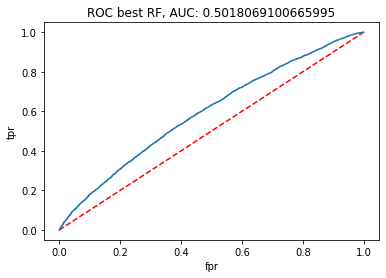

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

#### Matriz de confusión

In [56]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted_labels)

array([[   27,  5840],
       [   20, 20219]])

#### Accuracy

In [57]:
from sklearn.metrics import accuracy_score 
accuracy_score(y_test, predicted_labels)

0.7755305293802192

In [66]:
#### Precision, recall, thresholds
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [67]:
thresholds_2 = np.append(thresholds_2, 1)

In [68]:
(precision.shape, recall.shape, thresholds_2.shape)

((22429,), (22429,), (22429,))

#### Reporte de métricas

In [69]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [70]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.335893,0.775262,1.000000,0.873406,1.000000,1.000000,0.000000,0.000000
1,0.360067,0.775254,0.999951,0.873382,0.999951,1.000000,0.000000,0.000049
2,0.373192,0.775313,0.999951,0.873419,0.999951,0.999659,0.000341,0.000049
3,0.387657,0.775334,0.999901,0.873414,0.999901,0.999489,0.000511,0.000099
4,0.391410,0.775317,0.999802,0.873365,0.999802,0.999489,0.000511,0.000198
...,...,...,...,...,...,...,...,...
11142,0.926963,0.750000,0.000445,0.000889,0.000445,0.000511,0.999489,0.999555
11143,0.927962,0.900000,0.000445,0.000889,0.000445,0.000170,0.999830,0.999555
11144,0.928451,1.000000,0.000445,0.000889,0.000445,0.000000,1.000000,0.999555
11145,0.928932,1.000000,0.000346,0.000691,0.000346,0.000000,1.000000,0.999654


¿Cuál es el threshold que tendríamos que escoger para que no tengamos más de 6% de FP?

In [71]:
negocio = metrics_report[metrics_report.fpr <= 0.06]
negocio

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
10265,0.824324,0.866743,0.112802,0.199624,0.112802,0.059826,0.940174,0.887198
10266,0.824326,0.867021,0.112753,0.199554,0.112753,0.059656,0.940344,0.887247
10267,0.824353,0.866971,0.112703,0.199475,0.112703,0.059656,0.940344,0.887297
10268,0.824356,0.867300,0.112703,0.199484,0.112703,0.059485,0.940515,0.887297
10269,0.824388,0.867250,0.112654,0.199405,0.112654,0.059485,0.940515,0.887346
...,...,...,...,...,...,...,...,...
11142,0.926963,0.750000,0.000445,0.000889,0.000445,0.000511,0.999489,0.999555
11143,0.927962,0.900000,0.000445,0.000889,0.000445,0.000170,0.999830,0.999555
11144,0.928451,1.000000,0.000445,0.000889,0.000445,0.000000,1.000000,0.999555
11145,0.928932,1.000000,0.000346,0.000691,0.000346,0.000000,1.000000,0.999654


# Modeling

In [72]:
def magic_loop(algorithms, df):
    """
    Evaluación de metodología Magic Loop en la etapa de modeling
    :param: Algoritmos a evaluar y el dataframe
    :return: mejor modelo
    """
    # Procesamiento de datos
    X = df
    y = df.label
    X = pd.DataFrame(X.drop(['label'], axis=1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=None)

    # Magic Loop
    algorithms_dict = {'tree': 'tree_grid_search',
                       'random_forest': 'rf_grid_search'}
    grid_search_dict = {'tree_grid_search': {'max_depth': [5, 10, 15, None],
                                             'min_samples_leaf': [3, 5, 7]},
                        'rf_grid_search': {'n_estimators': [30, 50, 100],
                                           'max_depth': [5, 10],
                                           'min_samples_leaf': [3, 5]}}

    estimators_dict = {'tree': DecisionTreeClassifier(random_state=1111),
                       'random_forest': RandomForestClassifier(oob_score=True, random_state=2222)}

    # Empezar proceso
    best_estimators = []
    start_time = time.time()
    for algorithm in algorithms:
        estimator = estimators_dict[algorithm]
        grid_search_to_look = algorithms_dict[algorithm]
        grid_params = grid_search_dict[grid_search_to_look]

        tscv = TimeSeriesSplit(n_splits=5)
        gs = GridSearchCV(estimator, grid_params, scoring='precision', cv=tscv, n_jobs=3)

        # train
        gs.fit(X_train, y_train)
        # best estimator
        best_estimators.append(gs)

    print("Tiempo de ejecución: ", time.time() - start_time)

    # Seleccionar el de mejor desempeño
    models_develop = [best_estimators[0].best_score_, best_estimators[1].best_score_]
    max_score = max(models_develop)
    max_index = models_develop.index(max_score)
    best_model = best_estimators[max_index]

    print('Mejor modelo: ', best_model.best_estimator_)
    print('Mejor desempeño: ', best_model.best_score_)
    return best_model

def save_models(model, path = 'output/model_loop_DPA.pkl'):
    save_df(model, path)


    


In [73]:
print("Iniciando modelado")
start_time = time.time()
# Cargamos datos
#df = load_features(path)
algorithms = ['tree', 'random_forest']
# Obtenemos el modelo
model = magic_loop(algorithms, df)
# Guardamos el modelo
#save_models(model)
pickle.dump(df, open('output/model_loop_DPA.pkl', "wb"))##en jupyter
print("Terminó modelado en ", time.time() - start_time)

Iniciando modelado
Tiempo de ejecución:  45.30095052719116
Mejor modelo:  DecisionTreeClassifier(min_samples_leaf=7, random_state=1111)
Mejor desempeño:  0.780697336378292
Terminó modelado en  45.69310712814331
